In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
ticks = [-np.pi/2, -5*np.pi/12, -np.pi/3, -np.pi/4, -np.pi/6, -np.pi/12, 0, np.pi/12, np.pi/6, np.pi/4, np.pi/3, 5*np.pi/12, np.pi/2]
labels = [r"$-\frac{\pi}{2}$", r"$-\frac{5\pi}{12}$", r"$-\frac{\pi}{3}$", r"$-\frac{\pi}{4}$", r"$-\frac{\pi}{6}$", r"$-\frac{\pi}{12}$", r"$0$", 
          r"$\frac{\pi}{12}$", r"$\frac{\pi}{6}$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{3}$", r"$\frac{5\pi}{12}$", r"$\frac{\pi}{2}$"]

from ArrayModel import *
from utils import *
from models import *

In [2]:
d = 1
m = 8
t = 200
snr = 20
lamda = 0.2
distance = 0.1

array = ULA(m, lamda)
array.build_sensor_positions(distance)
array.build_array_manifold()

In [3]:
theta_min = -torch.pi/2 + 0.1
theta_max = torch.pi/2 - 0.1
nb_theta = 100000
theta = torch.linspace(theta_min, theta_max, nb_theta)

A = array.get_steering_vector(theta.unsqueeze(-1), return_first_derivative=False)
S = (torch.randn(theta.shape[0], d, t) + 1j * torch.randn(theta.shape[0], d, t)) / sqrt(2) 
N = (torch.randn(theta.shape[0], m, t) + 1j * torch.randn(theta.shape[0], m, t)) / sqrt(2) / 10 ** (snr / 20) 
X = A @ S + N

In [4]:
# results_music = torch.zeros(theta.shape[0])
# for i in range(X.shape[0]):
#     results_music[i], _, _ = MUSIC(X[i], d, array)

# plt.scatter(theta, results_music, marker='.', s=0.3, label='MUSIC', color='red')
# plt.plot(theta, theta, label='Expected line', color='blue')
# plt.xticks(ticks=ticks, labels=labels);
# plt.yticks(ticks=ticks, labels=labels);
# plt.title("MUSIC")
# plt.grid(True)
# plt.legend()  

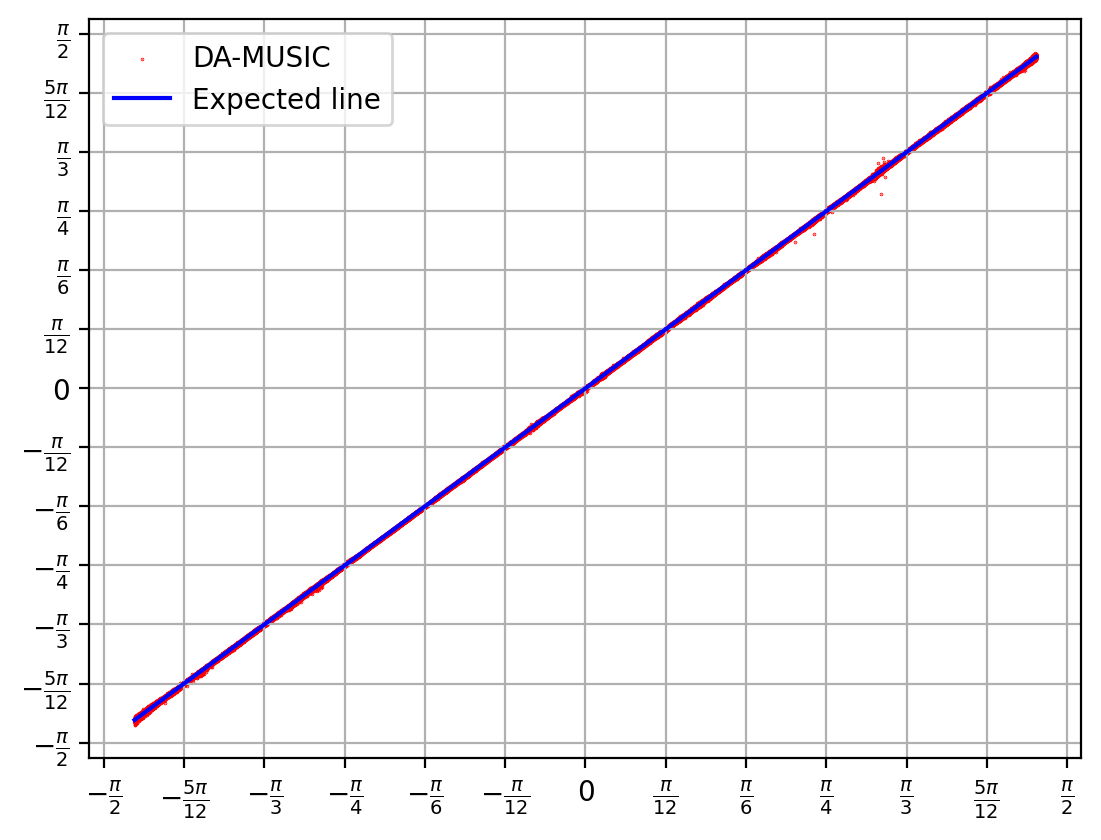

In [5]:
path = 'saved_models_rmspe/'

damusic = DA_MUSIC(m, d, array, 'cuda')
damusic.load_state_dict(torch.load(path+'da_music_20dB.pth', weights_only=True))

theta_damusic = torch.zeros_like(theta)
batchSize = 5000
for i in range(int(theta.shape[0]/batchSize)):
    theta_damusic[batchSize*i:batchSize*(i+1)] = damusic(X[batchSize*i:batchSize*(i+1)].transpose(1, 2).to(dev)).squeeze(-1).cpu().detach()
theta_damusic_modulo = torch.remainder(theta_damusic + torch.pi/2, torch.pi) - torch.pi/2

plt.scatter(theta, theta_damusic_modulo, marker='.', s=0.3, label='DA-MUSIC', color='red');
plt.plot(theta, theta, label='Expected line', color='blue');
plt.grid(True);
plt.legend();
plt.xticks(ticks=ticks, labels=labels);
plt.yticks(ticks=ticks, labels=labels);

In [6]:
# damusic.load_state_dict(torch.load('saved_models_polynomial/da_music_20dB.pth', weights_only=True))

# theta_damusic_2 = torch.zeros_like(theta)
# batchSize = 5000
# for i in range(int(theta.shape[0]/batchSize)):
#     theta_damusic_2[batchSize*i:batchSize*(i+1)] = damusic(X[batchSize*i:batchSize*(i+1)].transpose(1, 2).to(dev)).squeeze(-1).cpu().detach()
# theta_damusic_2 = torch.remainder(theta_damusic_2 + torch.pi/2, torch.pi) - torch.pi/2

# plt.scatter(theta, theta_damusic_2, marker='.', s=0.3, label='DA-MUSIC', color='red');
# plt.plot(theta, theta, label='Expected line', color='blue');
# plt.title("DA-MUSIC after Thierry's regularization")
# plt.grid(True);
# plt.legend();
# plt.xticks(ticks=ticks, labels=labels);
# plt.yticks(ticks=ticks, labels=labels);

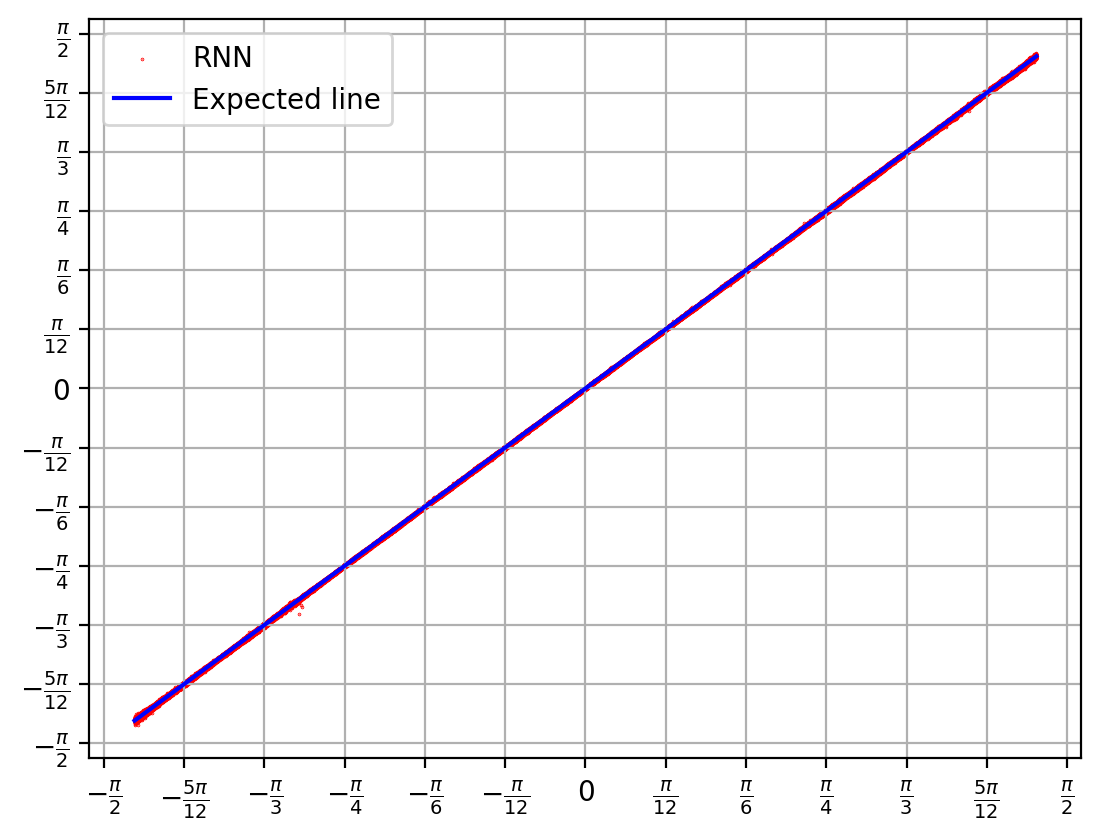

In [7]:
rnn = RNN(m, d, 'cuda')
rnn.load_state_dict(torch.load(path+'rnn_20dB.pth', weights_only=True))

theta_rnn = torch.zeros_like(theta)
batchSize = 5000
for i in range(int(theta.shape[0]/batchSize)):
    theta_rnn[batchSize*i:batchSize*(i+1)] = rnn(X[batchSize*i:batchSize*(i+1)].transpose(1, 2).to(dev)).squeeze(-1).cpu().detach()
theta_rnn_modulo = torch.remainder(theta_rnn + torch.pi/2, torch.pi) - torch.pi/2

plt.scatter(theta, theta_rnn_modulo, marker='.', s=0.3, label='RNN', color='red');
plt.plot(theta, theta, label='Expected line', color='blue');
plt.grid(True);
plt.legend();
plt.xticks(ticks=ticks, labels=labels);
plt.yticks(ticks=ticks, labels=labels);

In [8]:
# rnn.load_state_dict(torch.load('saved_models_polynomial/rnn_20dB.pth', weights_only=True))

# theta_rnn_2 = torch.zeros_like(theta)
# batchSize = 5000
# for i in range(int(theta.shape[0]/batchSize)):
#     theta_rnn_2[batchSize*i:batchSize*(i+1)] = rnn(X[batchSize*i:batchSize*(i+1)].transpose(1, 2).to(dev)).squeeze(-1).cpu().detach()
# theta_rnn_2 = torch.remainder(theta_rnn_2 + torch.pi/2, torch.pi) - torch.pi/2

# plt.scatter(theta, theta_rnn_2, marker='.', s=0.3, label='RNN', color='red');
# plt.plot(theta, theta, label='Expected line', color='blue');
# plt.title("RNN after Thierry's regularization");
# plt.grid(True);
# plt.legend();
# plt.xticks(ticks=ticks, labels=labels);
# plt.yticks(ticks=ticks, labels=labels);